In [30]:
import os
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import datasets, preprocessing, models, layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
Data = pd.read_csv('src/data/airquality-dataset/sample_dataset.csv', index_col=0, chunksize=50)

In [5]:
Data.get_chunk().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   channel_id  50 non-null     int64  
 1   pm2_5       50 non-null     float64
 2   pm10        50 non-null     float64
 3   s2_pm2_5    50 non-null     float64
 4   s2_pm10     50 non-null     float64
 5   Site        50 non-null     object 
 6   TimeStamp   50 non-null     object 
dtypes: float64(4), int64(1), object(2)
memory usage: 3.1+ KB


In [ ]:
trai

In [6]:
dataType = {'channel_id' : 'uint32',
            'pm2_5' : 'float32',
            'pm10' : 'float32',
            's2_pm2_5' : 'float32',
            's2_pm10' : 'float32',
            'Site' : 'str',
            'TimeStamp' : 'str'
           }

In [7]:
def load_data(dataPath, dataType: dict) -> pd.core.frame.DataFrame:
    data = pd.read_csv(dataPath, dtype=dataType, index_col=0)
    data = data.drop_duplicates(ignore_index=True)
    data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
    
    return data

In [8]:
data = load_data(dataPath='src/data/airquality-dataset/sample_dataset.csv', dataType=dataType)

/home/usman/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
data.head()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10,Site,TimeStamp
0,912223,37.020000,45.230000,34.070000,39.820000,"Banda, Kampala",2019-11-27 13:24:45
1,912223,41.700001,50.700001,38.549999,47.430000,"Banda, Kampala",2019-11-27 13:26:13
2,912223,42.150002,52.869999,40.549999,49.950001,"Banda, Kampala",2019-11-27 13:30:53
3,912223,45.099998,57.020000,44.750000,55.029999,"Banda, Kampala",2019-11-27 13:32:22
4,912223,41.720001,52.080002,40.000000,49.200001,"Banda, Kampala",2019-11-27 13:33:46


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23530784 entries, 0 to 23530783
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   channel_id  uint32        
 1   pm2_5       float32       
 2   pm10        float32       
 3   s2_pm2_5    float32       
 4   s2_pm10     float32       
 5   Site        object        
 6   TimeStamp   datetime64[ns]
dtypes: datetime64[ns](1), float32(4), object(1), uint32(1)
memory usage: 807.9+ MB


In [11]:
channelSite = dict(zip(data['channel_id'].unique(), data['Site'].unique()))

In [12]:
siteGroups = data.groupby('channel_id')

In [197]:
# for x in siteGroups.groups:
#     if not os.path.exists('data_group'):
#         os.makedirs('data_group')
#     siteGroups.get_group(x).to_csv(f'data_group/{x}.csv')

In [14]:
def readChannel(channelId: int, dataPath='src/data/data_group/') -> pd.core.frame.DataFrame:
    path = dataPath + str(channelId) + '.csv'
    channelData = pd.read_csv(path, index_col=0, parse_dates=['TimeStamp'])
    return channelData

In [15]:
channel_one = readChannel(channelId=list(channelSite.keys())[0])

In [15]:
channel_one = readChannel(channelId=list(channelSite.keys())[0])

In [146]:
channel_one_new2 = preprocess(channel_one, ['hour', 'day', 'month', 'day_of_week', 'week_of_year'])

In [145]:
def getFeatures(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    
    df = df.drop(labels='channel_id', axis=1).set_index(['TimeStamp']).resample('H').mean().fillna(method='ffill')
    #df = df.drop(labels='channel_id', axis=1).groupby(pd.Grouper(key='TimeStamp', freq='1H')).mean().fillna(method='ffill')
    df = df.assign(hour = df.index.hour,
                   day = df.index.day,
                   month = df.index.month,
                   day_of_week = df.index.dayofweek,
                   week_of_year = df.index.week)
    
    return df

def generate_cyclical_features(df: pd.core.frame.DataFrame, col_name: list) -> pd.core.frame.DataFrame:
    
    
    for time_col in col_name:
        kwargs = {
            f'sin_{time_col}' :lambda x: np.sin(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique()),
            f'cos_{time_col}' :lambda x: np.cos(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique())    
                 }
        df_time = df.assign(**kwargs)[['sin_'+time_col, 'cos_'+time_col]]
        
        df = pd.concat([df, df_time], axis=1)
    
    return df

def oneHotEncoding(df: pd.core.frame.DataFrame, col_name:list) -> pd.core.frame.DataFrame:
    
    return pd.get_dummies(data=df, columns=col_name, drop_first=True)

def preprocess(df, col_list=['hour', 'day', 'month', 'day_of_week', 'week_of_year']):

    df = getFeatures(df)
    df = generate_cyclical_features(df, col_list)
    df = oneHotEncoding(df, col_list)

    return df

In [148]:
target=['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10']

In [20]:
channel_one_new.resample('H').mean()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10
TimeStamp,,,,,
2019-11-27 13:00:00,912223.0,41.258947,51.221579,39.366842,48.085263
2019-11-27 14:00:00,912223.0,35.883077,43.583846,33.868718,39.694359
2019-11-27 15:00:00,912223.0,40.329231,49.360769,38.259744,46.074359
2019-11-27 16:00:00,912223.0,79.226667,90.660238,73.879048,84.298810
2019-11-27 17:00:00,912223.0,81.079250,90.701000,75.360000,84.586750
...,...,...,...,...,...
2021-11-16 02:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 03:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 04:00:00,NaN,NaN,NaN,NaN,NaN


<Figure size 1008x720 with 0 Axes>

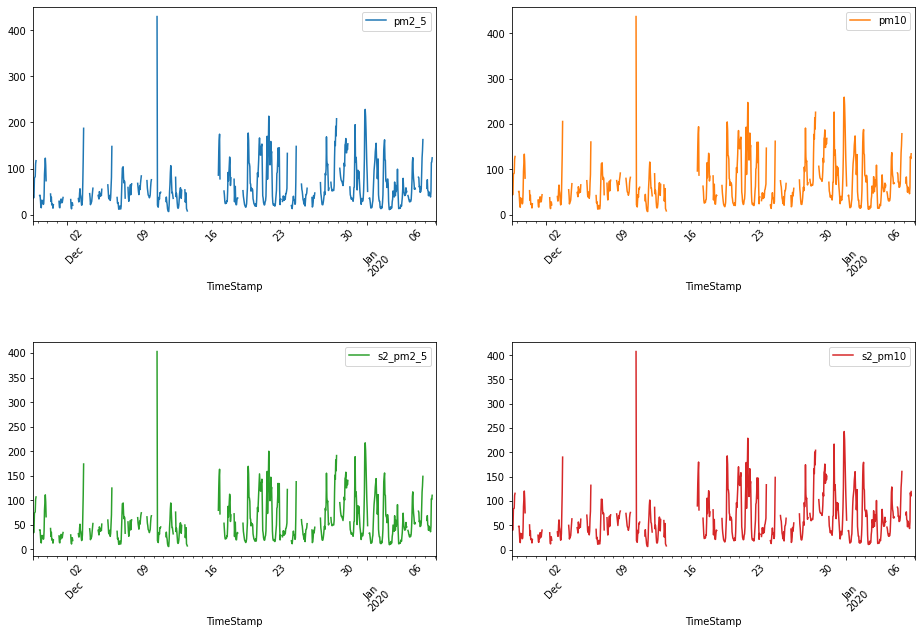

In [26]:
fig = plt.figure(figsize=(14,10))
channel_one_new[:1000].drop('channel_id', axis=1).plot(subplots=True, layout=(2,2),
                                                              figsize=(14,10), sharex=False, rot=45)
plt.tight_layout(pad=5)

In [278]:
batch_data = TimeseriesGenerator(data=channel_one_new2.to_numpy(), targets=channel_one_new2['pm2_5'].to_numpy().reshape(-1,1), length=24, sampling_rate=1, batch_size=100)

In [279]:
batch_0 = batch_data[0]
x, y = batch_0
print(y.shape)

(100, 1)


In [305]:
channel_one_new2.shape

(17274, 136)

In [254]:
x

array([[[41.25894737, 51.22157895, 39.36684211, 48.08526316,
         -0.25881905, -0.96592583, -0.84864426,  0.52896401,
         -0.8660254 ,  0.5       ,  0.97492791, -0.22252093,
         -0.65282212,  0.75751124,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0

In [256]:
y

array([ 82.61571429, 110.5208    , 116.99      , 116.99      ,
       116.99      ])

In [239]:
y

array([35.88307692, 40.32923077, 79.22666667, 81.07925   , 82.61571429])

In [240]:
channel_one_new2[:20]

,pm2_5,pm10,s2_pm2_5,s2_pm10,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2019-11-27 13:00:00,41.258947,51.221579,39.366842,48.085263,-0.258819,-9.659258e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 14:00:00,35.883077,43.583846,33.868718,39.694359,-0.500000,-8.660254e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 15:00:00,40.329231,49.360769,38.259744,46.074359,-0.707107,-7.071068e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 16:00:00,79.226667,90.660238,73.879048,84.298810,-0.866025,-5.000000e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 17:00:00,81.079250,90.701000,75.360000,84.586750,-0.965926,-2.588190e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 18:00:00,82.615714,91.975714,76.539143,85.343143,-1.000000,-1.836970e-16,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 19:00:00,110.520800,122.654400,102.071200,111.690000,-0.965926,2.588190e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 20:00:00,116.990000,128.516667,106.956667,115.806667,-0.866025,5.000000e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0
2019-11-27 21:00:00,116.990000,128.516667,106.956667,115.806667,-0.707107,7.071068e-01,-0.848644,0.528964,-0.866025,0.5,...,0,0,0,0,1,0,0,0,0,0


In [246]:
batch_1 = DDD[1]
x1, y1 = batch_1
print(y1.shape)

(5,)


In [248]:
x1.shape

(5, 1, 136)

In [249]:
x1

array([[[ 8.26157143e+01,  9.19757143e+01,  7.65391429e+01,
          8.53431429e+01, -1.00000000e+00, -1.83697020e-16,
         -8.48644257e-01,  5.28964010e-01, -8.66025404e-01,
          5.00000000e-01,  9.74927912e-01, -2.22520934e-01,
         -6.52822118e-01,  7.57511242e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+0

In [274]:
dataa = np.array([[i] for i in range(50)])
targets = np.array([[i] for i in range(50)])
data_gen = TimeseriesGenerator(dataa, targets,
                               length=10, sampling_rate=2,
                               batch_size=2)

In [277]:
data_gen[0][1].shape

(2, 1)

In [250]:
y1

array([110.5208, 116.99  , 116.99  , 116.99  , 116.99  ])

In [272]:
TimeseriesGenerator?

In [312]:
model.fit?

In [281]:
model = models.Sequential([
    layers.Dense(100, input_shape=(x.shape[1], x.shape[2]), activation='relu'),
    layers.Flatten(),
    layers.Dense(1)
])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24, 100)           13700     
                                                                 
 flatten_4 (Flatten)         (None, 2400)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 2401      
                                                                 
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________
None


In [282]:
model.compile(optimizer='adam', loss='mse')

In [313]:
history = model.fit(batch_data, epochs=5)

Epoch 1/5
173/173 [==============================] - 2s 9ms/step - loss: 12751.5635
Epoch 2/5
173/173 [==============================] - 1s 7ms/step - loss: 14747.6455
Epoch 3/5
173/173 [==============================] - 1s 5ms/step - loss: 13268.9854
Epoch 4/5
173/173 [==============================] - 1s 5ms/step - loss: 16302.8906
Epoch 5/5
173/173 [==============================] - 1s 7ms/step - loss: 12849.8145


In [316]:
history.history

{'loss': [12751.5634765625,
  14747.6455078125,
  13268.9853515625,
  16302.890625,
  12849.814453125]}

In [317]:
plt.xticks?

In [295]:
model.evaluate(batch_data)

173/173 [==============================] - 1s 4ms/step - loss: 12362.2959


12362.2958984375

In [306]:
model.fit?

In [297]:
model.outputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_13')>]

In [293]:
YYY = model.evaluate(batch_data, verbose=0)

In [294]:
YYY

12362.2958984375

In [304]:
batch_data[0][0].shape[1:]

(24, 136)

RNN

In [289]:
x.shape

(100, 24, 136)

In [284]:
rnn_model = models.Sequential([
    layers.SimpleRNN(100, input_shape=(x.shape[1], x.shape[2]), dropout=0.5, recurrent_dropout=0.5),
    layers.Dense(1)
])
print(rnn_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               23700     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 23,801
Trainable params: 23,801
Non-trainable params: 0
_________________________________________________________________
None


In [286]:
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(batch_data, epochs=5)

Epoch 1/5
173/173 [==============================] - 4s 15ms/step - loss: 31362.1406
Epoch 2/5
173/173 [==============================] - 3s 16ms/step - loss: 30064.0371
Epoch 3/5
173/173 [==============================] - 3s 16ms/step - loss: 29527.4062
Epoch 4/5
173/173 [==============================] - 3s 16ms/step - loss: 29221.7930
Epoch 5/5
173/173 [==============================] - 3s 18ms/step - loss: 29038.9473


LSTM

In [287]:
lstm_model = models.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, recurrent_dropout=0.5), input_shape=(x.shape[1], x.shape[2])),
    layers.Bidirectional(layers.LSTM(100, recurrent_dropout=0.5)),
    layers.Dense(1)
])
print(lstm_model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 24, 200)          189600    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 430,601
Trainable params: 430,601
Non-trainable params: 0
_________________________________________________________________
None


In [288]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(batch_data, epochs=5)

Epoch 1/5
173/173 [==============================] - 38s 131ms/step - loss: 29832.6445
Epoch 2/5
173/173 [==============================] - 24s 139ms/step - loss: 29054.2832
Epoch 3/5
173/173 [==============================] - 23s 130ms/step - loss: 28570.3887
Epoch 4/5
173/173 [==============================] - 26s 152ms/step - loss: 28266.8301
Epoch 5/5
173/173 [==============================] - 23s 132ms/step - loss: 28039.3555


In [330]:
channel_one.groupby(pd.Grouper(key='TimeStamp', freq='1H')).mean()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10
TimeStamp,,,,,
2019-11-27 13:00:00,912223.0,41.258947,51.221579,39.366842,48.085263
2019-11-27 14:00:00,912223.0,35.883077,43.583846,33.868718,39.694359
2019-11-27 15:00:00,912223.0,40.329231,49.360769,38.259744,46.074359
2019-11-27 16:00:00,912223.0,79.226667,90.660238,73.879048,84.298810
2019-11-27 17:00:00,912223.0,81.079250,90.701000,75.360000,84.586750
...,...,...,...,...,...
2021-11-16 02:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 03:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 04:00:00,NaN,NaN,NaN,NaN,NaN


In [368]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor

In [408]:
def getFeatures(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df = df.drop(labels='channel_id', axis=1).groupby(pd.Grouper(key='TimeStamp', freq='1H')).mean().fillna(method='ffill')
    df = df.assign(hour = KK.index.hour,
                   day = KK.index.day,
                   month = KK.index.month,
                   day_of_week = KK.index.dayofweek,
                   week_of_year = KK.index.week)
    
    return df

def generate_cyclical_features(df: pd.core.frame.DataFrame, col_name: list) -> pd.core.frame.DataFrame:
    
    
    for time_col in col_name:
        kwargs = {
            f'sin_{time_col}' :lambda x: np.sin(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique()),
            f'cos_{time_col}' :lambda x: np.cos(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique())    
                 }
        df_time = df.assign(**kwargs)[['sin_'+time_col, 'cos_'+time_col]]
        
        df = pd.concat([df, df_time], axis=1)
    
    return df

def oneHotEncoding(df: pd.core.frame.DataFrame, col_name:list) -> pd.core.frame.DataFrame:
    
    return pd.get_dummies(data=df, columns=col_name, drop_first=True)
    
    
def featureLabelSplit(df, target:list):
    Y = df[target].to_numpy()
    X = df.drop(columns=target).to_numpy()
    return (X,Y)
    
def train_test_spliting(X , Y, test_ratio:float):
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, shuffle=False)
    return X_train, Y_train, X_val, Y_val

In [446]:
def scaler_transform(X, Y, scaler="standard"):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "power": PowerTransformer,
        "robust": RobustScaler,
        "quantile": QuantileTransformer
    }
    
    scaler = scalers[scaler]()
    X = scaler.fit_transform(X)
    Y = scaler.fit_transform(Y)
    
    return scaler, X, Y

In [331]:
AA = getFeatures(channel_one)

In [334]:
BB = generate_cyclical_features(AA, ['hour', 'day', 'month',
       'day_of_week', 'week_of_year'])

In [348]:
CC = oneHotEncoding(BB, col_name=['hour', 'day', 'month','day_of_week', 'week_of_year'])

In [361]:
DD = featureLabelSplit(CC, target=['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10'])

In [362]:
P, Q = DD

In [409]:
P_train, Q_train, P_val, Q_val = train_test_spliting(P, Q, test_ratio=0.3)

In [456]:
scaler = RobustScaler()
P_train_scale = scaler.fit_transform(P_train)
P_val_scale = scaler.transform(P_val)

Q_train_scale = scaler.fit_transform(Q_train)
Q_val_scale = scaler.transform(Q_val)

In [457]:
clf = MultiOutputRegressor(estimator=Ridge()).fit(P_train_scale, Q_train_scale)

In [458]:
Y_pred = clf.predict(P_val_scale)

In [459]:
Y_pred

array([[-1.13109931e+00, -1.14459786e+00, -1.09916293e+00,
        -1.14221452e+00],
       [-1.22479924e+00, -1.23414573e+00, -1.20370056e+00,
        -1.24125185e+00],
       [-1.26355555e+00, -1.27095796e+00, -1.23730050e+00,
        -1.27265021e+00],
       ...,
       [-9.92626977e-02, -1.23147425e-01,  1.42712284e-01,
         9.52877928e-02],
       [ 6.32849306e-01,  4.93898803e-01,  4.87581634e-02,
        -1.03394804e-04],
       [-7.52379299e-02, -1.51281185e-01, -3.00242849e-01,
        -3.36449483e-01]])

In [461]:
scaler.inverse_transform(Y_pred)

array([[-2.99202452, -0.92966754,  3.56811309,  5.04850126],
       [-6.91736827, -5.28626198, -0.37708712,  0.65953674],
       [-8.54097516, -7.07721457, -1.64513304, -0.73192136],
       ...,
       [40.23440732, 48.76492963, 50.43589382, 59.88997832],
       [70.90456297, 78.78485303, 46.89010992, 55.66259742],
       [41.24086994, 47.39619374, 33.71897752, 40.75699592]])

In [462]:
Q_val

array([[10.7774359 , 11.75384615, 11.84435897, 13.20615385],
       [ 7.7197619 ,  8.49119048,  8.7297619 ,  9.60833333],
       [ 6.55266667,  7.19466667,  7.44688889,  8.08066667],
       ...,
       [55.364     , 75.686     , 53.398     , 65.636     ],
       [45.17      , 60.45      , 46.58      , 56.07      ],
       [44.58      , 62.68      , 41.23      , 50.88      ]])

In [463]:
Q_val_scale

array([[-0.80241538, -0.88389385, -0.87986378, -0.95813643],
       [-0.8754036 , -0.95095629, -0.96239256, -1.03932154],
       [-0.90326275, -0.97760577, -0.99638539, -1.07379346],
       ...,
       [ 0.26188827,  0.43020325,  0.22120045,  0.22494723],
       [ 0.01855238,  0.11703402,  0.04054105,  0.00908968],
       [ 0.00446878,  0.16287068, -0.10122014, -0.10802309]])

In [464]:
Y_pred

array([[-1.13109931e+00, -1.14459786e+00, -1.09916293e+00,
        -1.14221452e+00],
       [-1.22479924e+00, -1.23414573e+00, -1.20370056e+00,
        -1.24125185e+00],
       [-1.26355555e+00, -1.27095796e+00, -1.23730050e+00,
        -1.27265021e+00],
       ...,
       [-9.92626977e-02, -1.23147425e-01,  1.42712284e-01,
         9.52877928e-02],
       [ 6.32849306e-01,  4.93898803e-01,  4.87581634e-02,
        -1.03394804e-04],
       [-7.52379299e-02, -1.51281185e-01, -3.00242849e-01,
        -3.36449483e-01]])

In [455]:
Q_train_scale

array([[0.01191101, 0.01478711, 0.0650449 , 0.07795967],
       [0.01035905, 0.01258218, 0.0558709 , 0.06416411],
       [0.01164261, 0.01424991, 0.06319763, 0.07465352],
       ...,
       [0.02262745, 0.02567023, 0.12775503, 0.14026273],
       [0.00741109, 0.00825295, 0.04332026, 0.04878706],
       [0.00354595, 0.00382041, 0.02138817, 0.0221616 ]])

In [440]:
Q_val_scale

array([[0.00308034, 0.00335941, 0.04204783, 0.04108246],
       [0.00220641, 0.0024269 , 0.02852002, 0.02712673],
       [0.00187284, 0.00205633, 0.02294805, 0.021201  ],
       ...,
       [0.01582378, 0.02163208, 0.22253018, 0.24445473],
       [0.01291019, 0.01727742, 0.19291717, 0.20734878],
       [0.01274156, 0.01791479, 0.1696802 , 0.18721708]])

In [223]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["pm2_5"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [224]:
generate_time_lags(KK, 24)

,pm2_5,pm10,s2_pm2_5,s2_pm10,lag1,lag2,lag3,lag4,lag5,lag6,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2019-11-28 13:00:00,30.688611,34.675833,28.362222,31.460556,30.525405,25.983953,31.153611,14.856818,17.107442,31.133953,...,0.000000,0.000000,116.990000,110.520800,82.615714,81.079250,79.226667,40.329231,35.883077,41.258947
2019-11-28 14:00:00,22.213421,24.083947,20.923158,22.537632,30.688611,30.525405,25.983953,31.153611,14.856818,17.107442,...,0.000000,0.000000,0.000000,116.990000,110.520800,82.615714,81.079250,79.226667,40.329231,35.883077
2019-11-28 15:00:00,23.437436,26.122564,21.779487,23.848974,22.213421,30.688611,30.525405,25.983953,31.153611,14.856818,...,0.000000,0.000000,0.000000,0.000000,116.990000,110.520800,82.615714,81.079250,79.226667,40.329231
2019-11-28 16:00:00,40.217500,49.051500,37.680000,44.879250,23.437436,22.213421,30.688611,30.525405,25.983953,31.153611,...,0.000000,0.000000,0.000000,0.000000,0.000000,116.990000,110.520800,82.615714,81.079250,79.226667
2019-11-28 17:00:00,87.453721,96.437907,80.326047,88.528140,40.217500,23.437436,22.213421,30.688611,30.525405,25.983953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.990000,110.520800,82.615714,81.079250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.364000,39.253750,...,38.719070,31.557907,27.168864,26.934186,36.511628,41.242778,47.470000,0.000000,0.000000,0.000000
2021-11-16 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.364000,...,33.848372,38.719070,31.557907,27.168864,26.934186,36.511628,41.242778,47.470000,0.000000,0.000000
2021-11-16 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,35.956977,33.848372,38.719070,31.557907,27.168864,26.934186,36.511628,41.242778,47.470000,0.000000


In [257]:
KK.assign(hour=KK.index)

/home/usman/.local/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [259]:
feat = KK.assign(hour = KK.index.hour,
                 day = KK.index.day,
                 month = KK.index.month,
                 day_of_week = KK.index.dayofweek,
                 week_of_year = KK.index.week)

In [267]:
feat.day_of_week.nunique()

7

In [274]:
time_col = 'hour'

In [288]:
dico = {f'sin_{time_col}' :lambda x: np.sin(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique()),
        f'cos_{time_col}' :lambda x: np.cos(2*np.pi*(x[time_col] - x[time_col].min()) / x[time_col].nunique())}

In [290]:
np.sin(2*np.pi*(13-0)/24)

-0.2588190451025208

In [289]:
KK.assign(hour = KK.index.hour, month=KK.).assign(**dico)

,pm2_5,pm10,s2_pm2_5,s2_pm10,hour,sin_hour,cos_hour
TimeStamp,,,,,,,
2019-11-27 13:00:00,41.258947,51.221579,39.366842,48.085263,13,-0.258819,-9.659258e-01
2019-11-27 14:00:00,35.883077,43.583846,33.868718,39.694359,14,-0.500000,-8.660254e-01
2019-11-27 15:00:00,40.329231,49.360769,38.259744,46.074359,15,-0.707107,-7.071068e-01
2019-11-27 16:00:00,79.226667,90.660238,73.879048,84.298810,16,-0.866025,-5.000000e-01
2019-11-27 17:00:00,81.079250,90.701000,75.360000,84.586750,17,-0.965926,-2.588190e-01
...,...,...,...,...,...,...,...
2021-11-16 02:00:00,NaN,NaN,NaN,NaN,2,0.500000,8.660254e-01
2021-11-16 03:00:00,NaN,NaN,NaN,NaN,3,0.707107,7.071068e-01
2021-11-16 04:00:00,NaN,NaN,NaN,NaN,4,0.866025,5.000000e-01


In [302]:
KK.assign?

In [306]:
KKKK.agg?

In [308]:
KKKK['hour'].apply?

Object `apply` not found.


In [316]:
KKKK[['hour', 'month']].apply(lambda x: np.sin(2*np.pi*(x - x.min()) / x.nunique()), axis=1, result_type='expand')

,hour,month
TimeStamp,,
2019-11-27 13:00:00,-2.449294e-16,0.000000e+00
2019-11-27 14:00:00,3.673940e-16,0.000000e+00
2019-11-27 15:00:00,-4.898587e-16,0.000000e+00
2019-11-27 16:00:00,6.123234e-16,0.000000e+00
2019-11-27 17:00:00,-7.347881e-16,0.000000e+00
...,...,...
2021-11-16 02:00:00,0.000000e+00,1.102182e-15
2021-11-16 03:00:00,0.000000e+00,-9.797174e-16
2021-11-16 04:00:00,0.000000e+00,8.572528e-16


In [230]:
KK_features = (KK.assign)

DatetimeIndex(['2019-11-27 13:00:00', '2019-11-27 14:00:00',
               '2019-11-27 15:00:00', '2019-11-27 16:00:00',
               '2019-11-27 17:00:00', '2019-11-27 18:00:00',
               '2019-11-27 19:00:00', '2019-11-27 20:00:00',
               '2019-11-27 21:00:00', '2019-11-27 22:00:00',
               ...
               '2021-11-15 21:00:00', '2021-11-15 22:00:00',
               '2021-11-15 23:00:00', '2021-11-16 00:00:00',
               '2021-11-16 01:00:00', '2021-11-16 02:00:00',
               '2021-11-16 03:00:00', '2021-11-16 04:00:00',
               '2021-11-16 05:00:00', '2021-11-16 06:00:00'],
              dtype='datetime64[ns]', name='TimeStamp', length=17274, freq='H')

In [219]:
KK['pm2_5'].shift(1)

TimeStamp
2019-11-27 13:00:00          NaN
2019-11-27 14:00:00    41.258947
2019-11-27 15:00:00    35.883077
2019-11-27 16:00:00    40.329231
2019-11-27 17:00:00    79.226667
                         ...    
2021-11-16 02:00:00     0.000000
2021-11-16 03:00:00     0.000000
2021-11-16 04:00:00     0.000000
2021-11-16 05:00:00     0.000000
2021-11-16 06:00:00    45.170000
Freq: H, Name: pm2_5, Length: 17274, dtype: float64

In [213]:
KK['pm2_5']

TimeStamp
2019-11-27 13:00:00    41.258947
2019-11-27 14:00:00    35.883077
2019-11-27 15:00:00    40.329231
2019-11-27 16:00:00    79.226667
2019-11-27 17:00:00    81.079250
                         ...    
2021-11-16 02:00:00     0.000000
2021-11-16 03:00:00     0.000000
2021-11-16 04:00:00     0.000000
2021-11-16 05:00:00    45.170000
2021-11-16 06:00:00    44.580000
Freq: H, Name: pm2_5, Length: 17274, dtype: float64

In [203]:
channel_one.groupby(pd.Grouper(key='TimeStamp', freq='1H')).median()

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10
TimeStamp,,,,,
2019-11-27 13:00:00,912223.0,41.700,51.150,39.670,48.850
2019-11-27 14:00:00,912223.0,35.380,43.700,33.580,38.350
2019-11-27 15:00:00,912223.0,36.300,45.000,34.370,40.870
2019-11-27 16:00:00,912223.0,77.865,86.715,70.525,79.775
2019-11-27 17:00:00,912223.0,78.455,88.210,72.810,81.375
...,...,...,...,...,...
2021-11-16 02:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 03:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-16 04:00:00,NaN,NaN,NaN,NaN,NaN


In [227]:
KK.corr()

,pm2_5,pm10,s2_pm2_5,s2_pm10
pm2_5,1.000000,0.999412,0.255833,0.256373
pm10,0.999412,1.000000,0.282602,0.284030
s2_pm2_5,0.255833,0.282602,1.000000,0.997424
s2_pm10,0.256373,0.284030,0.997424,1.000000


In [87]:
channel_one.TimeStamp.dt

<bound method PandasDelegate._add_delegate_accessors.<locals>._create_delegator_method.<locals>.f of <pandas.core.indexes.accessors.DatetimeProperties object at 0x7fa35f1a1ca0>>

In [145]:
hour_mean = channel_one.groupby(channel_one.TimeStamp.dt.month)['pm2_5'].mean().to_numpy()

In [146]:
lower, upper = stats.t.interval(alpha=0.95, df=channel_one.groupby(channel_one.TimeStamp.dt.month)['pm2_5'].count()-1, 
                 loc=channel_one.groupby(channel_one.TimeStamp.dt.month)['pm2_5'].mean(),
                scale=channel_one.groupby(channel_one.TimeStamp.dt.month)['pm2_5'].std())

In [110]:
lower.reshape(-1,1).shape

(24, 1)

In [147]:
hour_mean

array([ 65.18920386,  59.82245696,  37.96603084,  25.8360199 ,
        29.70515476,  46.04323767,  87.03750805, 136.67150925,
        39.67616047,  44.26139234,  41.73948743,  53.339399  ])

In [125]:
pd.DataFrame?

In [148]:
DDD = pd.DataFrame(data=np.array([hour_mean, lower, upper]).T)

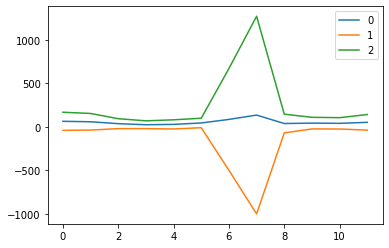

In [149]:
DDD.plot()

In [155]:
channel_one.groupby(channel_one.TimeStamp.dt.year)['pm2_5'].describe()

,count,mean,std,min,25%,50%,75%,max
TimeStamp,,,,,,,,
2019,16719.0,59.579169,47.443451,1.93,27.57,43.02,76.425,609.17
2020,237305.0,59.988219,224.187822,0.00,20.22,37.47,56.030,3663.30
2021,153028.0,47.896370,151.089488,0.00,18.27,34.50,50.380,3772.25


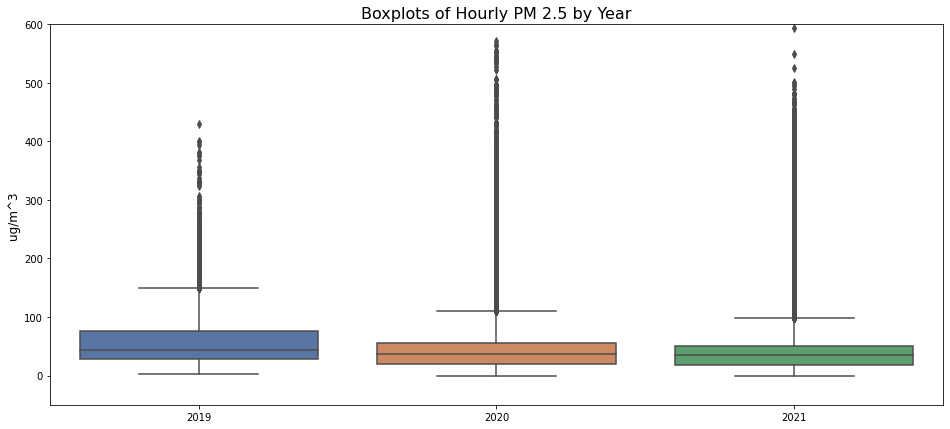

In [153]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x=channel_one.TimeStamp.dt.year, y='pm2_5', data=channel_one, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-50, 600))

plt.title('Boxplots of Hourly PM 2.5 by Year', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

In [ ]:
fig = plt.figure(figsize=(14,10))
testing[['date', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10']].plot(x='date', subplots=True, layout=(2,2),
                                                              figsize=(14,10), sharex=False, rot=45)
plt.tight_layout(pad=5)

In [25]:
#delta = datetime.timedelta(hours=24)

In [27]:
pd.to_numeric?

In [391]:
assert?

Object `assert` not found.


SyntaxError: invalid syntax (<ipython-input-392-cc3c8914aafa>, line 1)